### RFM ANALYSIS ON ONLINE RETAIL DATA SET 

Our dataset contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. </br>

The dataset contains information such as invoice data, price per unit of product, number of units purchased by each customer etc. Our goal is to segment the customers on basis of three factors: </br>

<ol>
    <li> <b> Recency </b> value which tells how recently the customer made the purchase. </li>
    <li> <b> Frequency</b> value whcih tells us how much the customer bought. </li>
    <li> <b> Monetary </b> value which tells the total amount spent by the customer. </li>
</ol>

Using these values, we form various number of clusters to segment the customers into and after finding the appropriate number of clusters, we make box plots to analyze which segment of customers can benefit the most to the business.

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

Enter the minimum number of clusters: 2
Enter the maximum number of clusters: 8


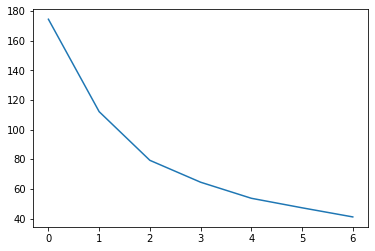

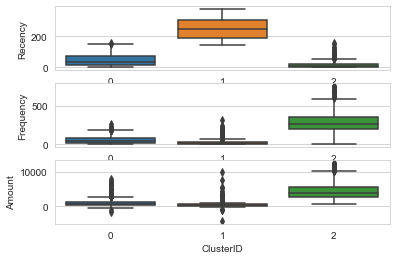

In [4]:
class RFM_analyzer:

    # Initializes the input path and range of number of clusters to try
    def __init__(self, input_path = '', num_clusters = None):

        # Setting the path to the dataset and the number of cluster that we want to cluster data in
        self.num_clusters = num_clusters
        self.input_path = input_path


    # Calls the appropriate function to start analysis
    def intialize_analysis(self):
        self.perform_analysis()


    # Performs the analysis on given data
    def perform_analysis(self):

        # Reading and preprocessing data
        df = self.read_and_preprocess_data(self.input_path)

        # Extracting the recency, frequency and monetary values from the data frame
        df_rfm = self.extract_information(df)

        # Determining the column names that can contain outlier values
        outlier_columns = list(df_rfm.columns)[1:]

        # Removing the outliers from the data set
        df_rfm_without_outliers = self.remove_outliers(df_rfm, outlier_columns)

        # Scaling the values in data frame
        rfm_to_be_scaled = df_rfm_without_outliers[['Recency', 'Frequency', 'Amount']]
        min_max = MinMaxScaler()
        scaled_rfm = min_max.fit_transform(rfm_to_be_scaled)

        # Converting the scaled into data frame
        rfm_final = pd.DataFrame(scaled_rfm, columns = ['Recency', 'Frequency', 'Amount'])

        # Performing cluster analysis
        optimal_cluster_value = self.calculate_optimal_cluster_value(self.num_clusters, rfm_final)

        # Performing clustering choosing the optimal number of clusters
        labels = self.perform_KMeans(optimal_cluster_value, rfm_final)

        # Appending the cluster IDs to the main data frame
        df_rfm_without_outliers['ClusterID'] = labels

        # Creating box plots to visualize the clusters created
        self.create_box_plots(df_rfm_without_outliers)


    # Performs pre-processing on the given data
    def read_and_preprocess_data(self, input_path = ''):
        # Creating dataframe from .xlsx file
        df = pd.read_csv(self.input_path)

        # Since there are missing values in CustomerID, we drop values
        df.dropna(inplace = True)

        # Returning the data frame
        return df


    # Extract recency, frequency and monetary information to perform RFM analysis
    def extract_information(self, df):
        # Creating the difference between latest purchase date available in the dataset and last purchase date of the
        # customer, the recency factor in the analysis
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%d-%m-%Y %H:%M')
        max_date = max(df['InvoiceDate'])
        df['Diff'] = max_date - df['InvoiceDate']
        df_r = df.groupby('CustomerID')['Diff'].min().reset_index()
        # Retaining only the days
        df_r['Diff'] = df_r['Diff'].dt.days

        # Calculating the frequency of purchase, the frequency factor of analysis
        df_f = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
        # Renaming the columns
        df_f.columns = ['CustomerID', 'Frequency']

        # Merging data frames accounting for recency and frequency factor
        df_rf = pd.merge(df_r, df_f, on = 'CustomerID', how = 'inner')

        # Calculating amount spent by each customer, the monetary factor of analysis
        df['Monetary'] = df['Quantity'] * df['UnitPrice']
        df_m = df.groupby('CustomerID')['Monetary'].sum().reset_index()

        # Final merged dataframe accounting for all 3 factors- recency, frequency and monetary
        df_rfm = pd.merge(df_rf, df_m, on = 'CustomerID', how = 'inner')
        df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Amount']

        # Returning the final dataframe for analysis
        return df_rfm


    # Removes outliers from the given data
    def remove_outliers(self, df = None, outlier_columns = None):

        # Removing the outliers from the dataset
        for col in outlier_columns:
            q1 = df[col].quantile(0.05)
            q2 = df[col].quantile(0.95)
            iqr = q2 - q1
            df = df[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q2 + 1.5 * iqr)]

        # Returning data frame without the outliers
        return df


    # Plots elbow curve of inertia value of clusters and performs quantitative analysis
    # to calculate optimum number of clusters
    def calculate_optimal_cluster_value(self, num_clusters, rfm_final):
        inertia_values = []
        for i in num_clusters:
            kmeans = KMeans(n_clusters = i, max_iter = 100)
            kmeans.fit(rfm_final)
            inertia_values.append(kmeans.inertia_)

        # Plotting the elbow curve to decide the optimal number of clusters
        plt.plot(inertia_values)
        plt.show()

        # Creating dictionary with "inertia_value" as the key and "num_clusters" as the value
        inertia_cluster_dict = dict(zip(inertia_values, num_clusters))

        # Calculating the optimal cluster value
        max_diff = -sys.maxsize
        optimal_cluster_value = 0
        for i in range(1, len(inertia_values)):
            diff = abs(inertia_values[i] - inertia_values[i - 1])

            # We update the optimal cluster value whenever there is a steep decline in the difference of the inertial values
            if (diff > max_diff):
                max_diff = diff
                optimal_cluster_value = inertia_cluster_dict[inertia_values[i]]

        # Returning the inertia values for different number of clusters
        return optimal_cluster_value


    # Performs KMeans on the basis of optimal cluster value found
    def perform_KMeans(self, cluster_value=None, rfm_final=None):

        # Performing clustering choosing the optimal number of clusters
        kmeans = KMeans(n_clusters=cluster_value, max_iter=100)
        kmeans.fit(rfm_final)
        labels = kmeans.labels_

        # Returning the cluster indices
        return labels


    # Makes box plots to compare various customer segments
    def create_box_plots(self, df):

        # Setting the seaborn style
        sns.set_style('whitegrid')
        
        # Creating sub-plots
        fig, axes = plt.subplots(3, 1)

        # Using box plots to visualize segmentation
        sns.boxplot(ax = axes[0], x = 'ClusterID', y = 'Recency', data = df)
        axes[0].set_xlabel('ClusterID')
        axes[0].set_ylabel('Recency')

        # Using box plots to visualize segmentation
        sns.boxplot(ax = axes[1], x = 'ClusterID', y = 'Frequency', data = df)
        axes[1].set_xlabel('ClusterID')
        axes[1].set_ylabel('Frequency')

        # Using box plots to visualize segmentation
        sns.boxplot(ax = axes[2],  x = 'ClusterID', y = 'Amount', data = df)
        axes[2].set_xlabel('ClusterID')
        axes[2].set_ylabel('Amount')

        # Displaying the plot
        plt.show()


if __name__ == '__main__':
    input_path = r'C:\Users\karan\Documents\Lakehead\Winter_2021\AI\Assignments\Assignment_2\online_retail.csv'

    # Taking inputs from the user for the starting and ending range of cluster
    min_clusters = int(input('Enter the minimum number of clusters: '))
    max_clusters = int(input('Enter the maximum number of clusters: '))

    # Implementing KMeans and deciding the optimal number of clusters using elbow method
    num_clusters = [i for i in range(min_clusters, max_clusters + 1)]

    # Starting analysis by instantiating the analyzer class
    analyzer = RFM_analyzer(input_path, num_clusters)
    analyzer.intialize_analysis()